In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd


In [3]:

# Load your dataset (replace 'your_dataset.csv' with your actual dataset file)
data = pd.read_csv('../data/results_2223_with_gw.csv')
data

,date,home_team,away_team,home_score,away_score,gameweek
0,2022-08-05T19:00:00Z,Crystal Palace,Arsenal,0,2,1
1,2022-08-06T11:30:00Z,Fulham,Liverpool,2,2,1
2,2022-08-06T14:00:00Z,Bournemouth,Aston Villa,2,0,1
3,2022-08-06T14:00:00Z,Leeds,Wolves,2,1,1
4,2022-08-06T14:00:00Z,Newcastle,Nott'm Forest,2,0,1
...,...,...,...,...,...,...
375,2023-05-28T15:30:00Z,Everton,Bournemouth,1,0,38
376,2023-05-28T15:30:00Z,Leeds,Spurs,1,4,38
377,2023-05-28T15:30:00Z,Leicester,West Ham,2,1,38
378,2023-05-28T15:30:00Z,Man Utd,Fulham,2,1,38


In [4]:

data['score_difference'] = data['home_score'] - data['away_score']
# Selecting relevant columns for prediction
selected_features = ['home_score', 'away_score', 'gameweek', 'home_team', 'away_team']
target = 'score_difference'  # Assuming you have a column for the target variable 'score_difference'

# Encoding categorical variables (home_team and away_team)
label_encoder = LabelEncoder()
data['home_team'] = label_encoder.fit_transform(data['home_team'])
data['away_team'] = label_encoder.transform(data['away_team'])

# Preprocessing data
X = data[selected_features]
y = data[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train.astype(np.float32).values)
y_train_tensor = torch.from_numpy(y_train.astype(np.float32).values)
X_test_tensor = torch.from_numpy(X_test.astype(np.float32).values)
y_test_tensor = torch.from_numpy(y_test.astype(np.float32).values)

# Define the neural network architecture with team embeddings
class FootballScorePredictor(nn.Module):
    def __init__(self, input_size, team_vocab_size, embedding_dim, hidden_size, output_size):
        super(FootballScorePredictor, self).__init__()
        self.embedding_home = nn.Embedding(team_vocab_size, embedding_dim)
        self.embedding_away = nn.Embedding(team_vocab_size, embedding_dim)
        self.fc1 = nn.Linear(input_size + 2 * embedding_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    # Inside the forward method of FootballScorePredictor class
    def forward(self, x, home_team, away_team):
        home_team = home_team.long()  # Convert to LongTensor
        away_team = away_team.long()  # Convert to LongTensor
        
        embed_home = self.embedding_home(home_team)
        embed_away = self.embedding_away(away_team)
        x = torch.cat((x, embed_home, embed_away), dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Initialize the model, define loss function, optimizer, and embeddings parameters
input_size = len(selected_features)  # Update with the number of features
team_vocab_size = len(label_encoder.classes_)
embedding_dim = 10  # Dimensionality of team embeddings
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1  # Output size for regression (predicting score difference)
model = FootballScorePredictor(input_size, team_vocab_size, embedding_dim, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor, X_train_tensor[:, -2], X_train_tensor[:, -1])  # Pass team indices
    loss = criterion(outputs.squeeze(), y_train_tensor)  # Squeeze to make output 1D for MSE loss

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 1.2072
Epoch [200/1000], Loss: 0.0234
Epoch [300/1000], Loss: 0.0055
Epoch [400/1000], Loss: 0.0029
Epoch [500/1000], Loss: 0.0018
Epoch [600/1000], Loss: 0.0012
Epoch [700/1000], Loss: 0.0009
Epoch [800/1000], Loss: 0.0006
Epoch [900/1000], Loss: 0.0005
Epoch [1000/1000], Loss: 0.0004


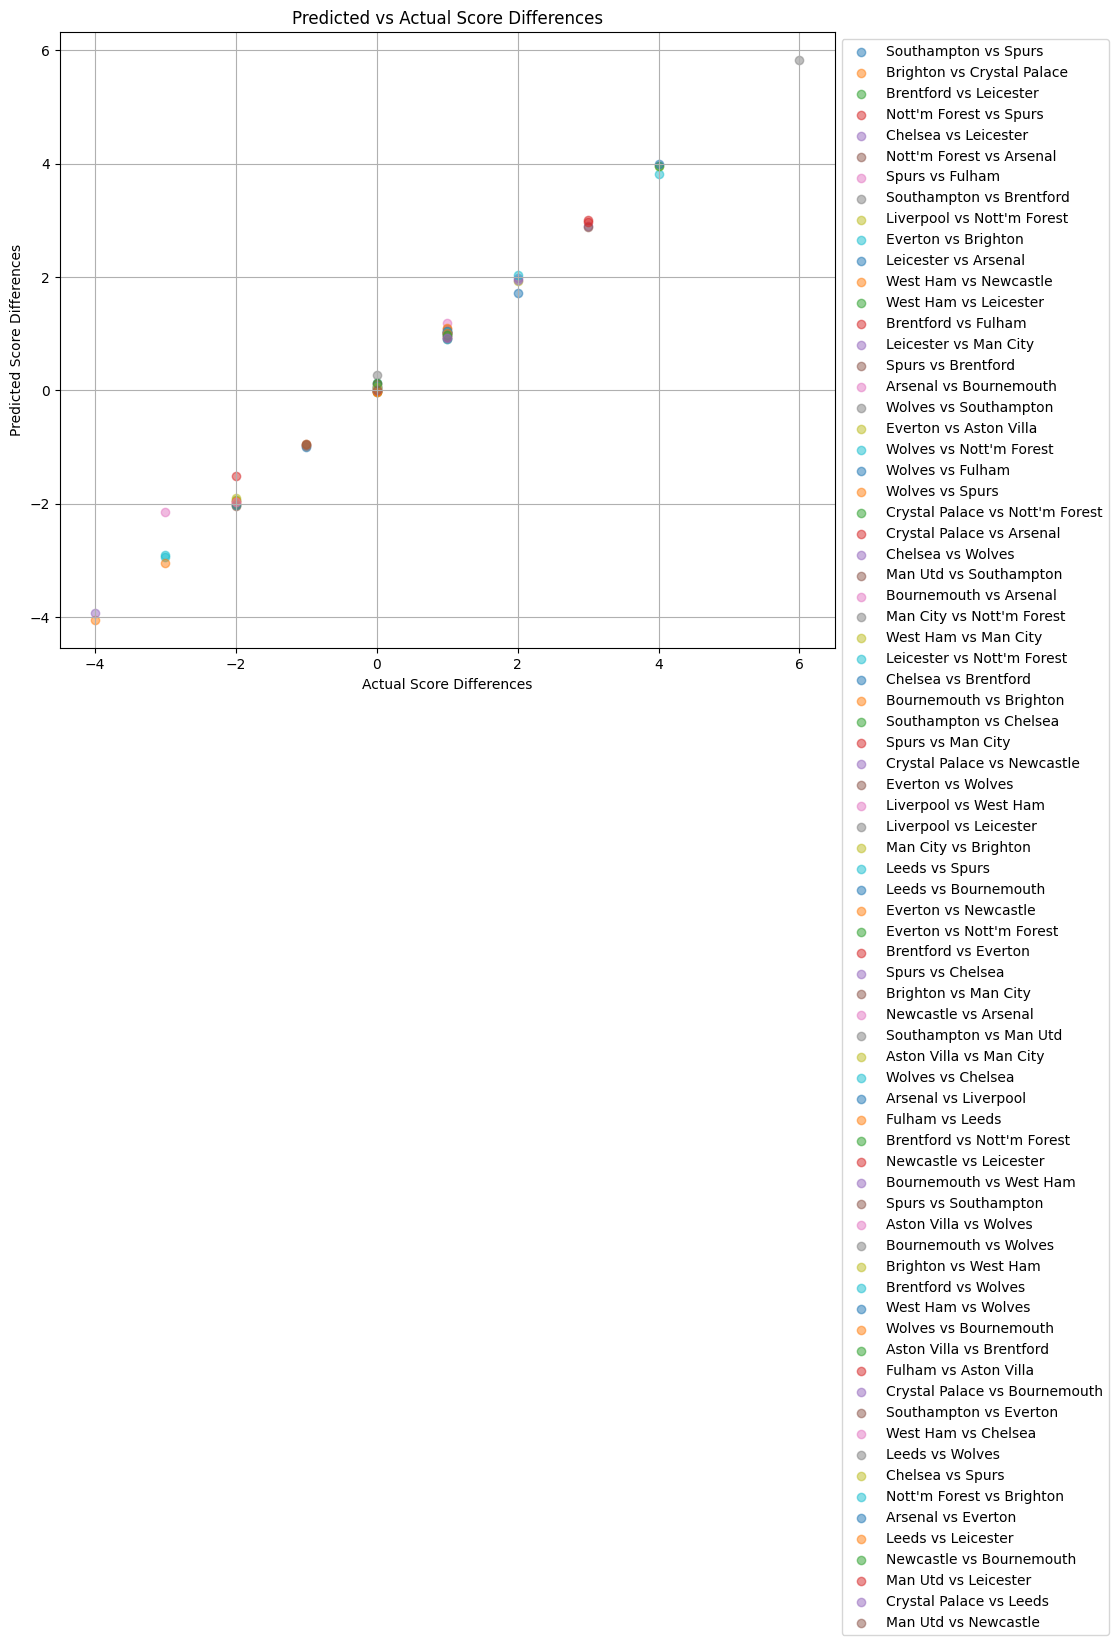

In [6]:
import matplotlib.pyplot as plt

# Inside the evaluation section
with torch.no_grad():
    outputs = model(X_test_tensor, X_test_tensor[:, -2], X_test_tensor[:, -1])  # Pass team indices
    outputs = outputs.squeeze().numpy()  # Convert predictions to NumPy array
    y_test_np = y_test_tensor.numpy()  # Convert actual scores to NumPy array
    home_teams = label_encoder.inverse_transform(X_test['home_team'])  # Inverse transform encoded home team labels
    away_teams = label_encoder.inverse_transform(X_test['away_team'])  # Inverse transform encoded away team labels

    # Create a scatter plot with team names as legends
    plt.figure(figsize=(10, 8))
    for i in range(len(outputs)):
        plt.scatter(y_test_np[i], outputs[i], alpha=0.5, label=f"{home_teams[i]} vs {away_teams[i]}")

    plt.title('Predicted vs Actual Score Differences')
    plt.xlabel('Actual Score Differences')
    plt.ylabel('Predicted Score Differences')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')  # Place legend outside the plot
    plt.grid(True)
    plt.show()


In [7]:
import plotly.express as px

# Inside the evaluation section
with torch.no_grad():
    outputs = model(X_test_tensor, X_test_tensor[:, -2], X_test_tensor[:, -1])  # Pass team indices
    outputs = outputs.squeeze().numpy()  # Convert predictions to NumPy array
    y_test_np = y_test_tensor.numpy()  # Convert actual scores to NumPy array
    home_teams = label_encoder.inverse_transform(X_test['home_team'])  # Inverse transform encoded home team labels
    away_teams = label_encoder.inverse_transform(X_test['away_team'])  # Inverse transform encoded away team labels

    # Create a DataFrame with the data
    df = pd.DataFrame({
        'Actual Score Differences': y_test_np,
        'Predicted Score Differences': outputs,
        'Home Team': home_teams,
        'Away Team': away_teams
    })

    # Create an interactive scatter plot using Plotly Express
    fig = px.scatter(df, x='Actual Score Differences', y='Predicted Score Differences',
                     color='Home Team', hover_data=['Away Team'])
    fig.update_traces(marker=dict(size=8, opacity=0.7),
                      selector=dict(mode='markers'))
    fig.update_layout(title='Predicted vs Actual Score Differences',
                      xaxis_title='Actual Score Differences',
                      yaxis_title='Predicted Score Differences')
    fig.show()
